<a href="https://colab.research.google.com/github/garthajon/QuantFinanceIntro/blob/main/ZSCORE_GARCH_PREDICTION_WITH_MONTE_CARLO_SIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 20.4 MB/s eta 0:00:00


/tmp/ipython-input-4196783709.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
/tmp/ipython-input-4196783709.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_sigma = res.conditional_volatility[-1]  # in scaled units
/tmp/ipython-input-4196783709.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_resid = res.resid[-1]


PLTR simulation done


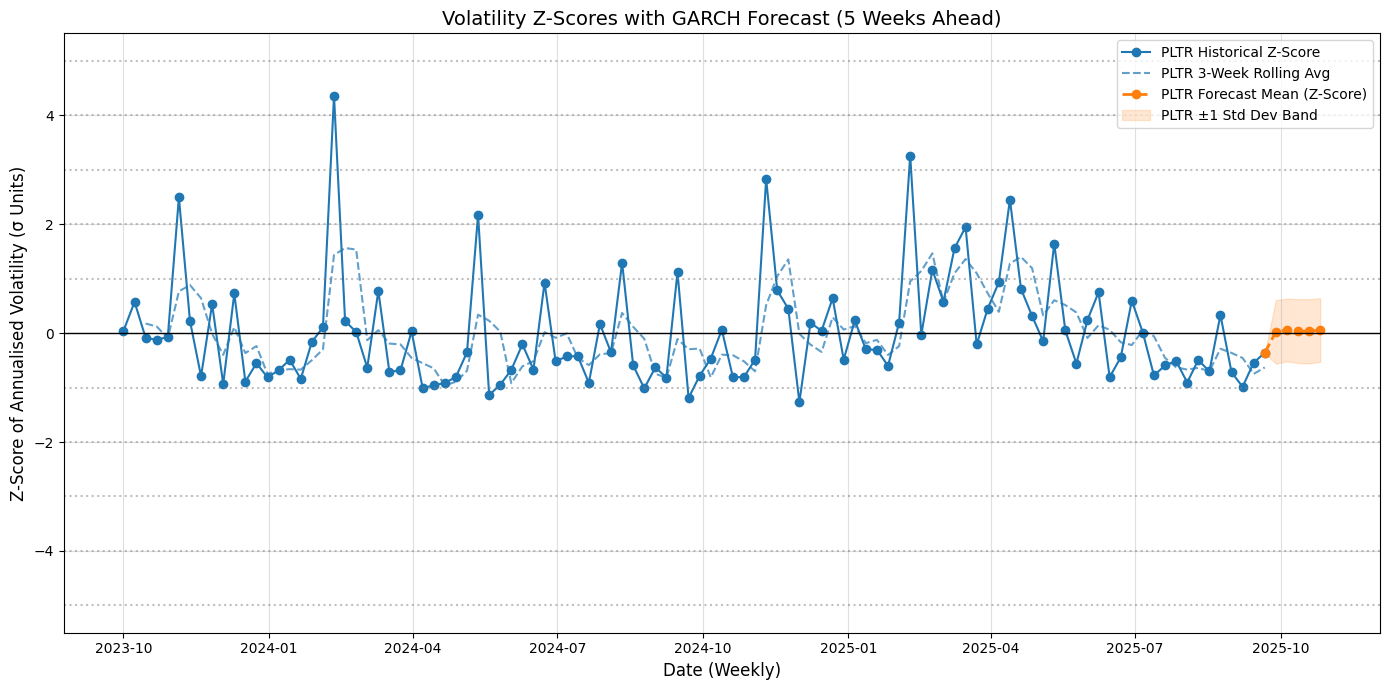

In [5]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# ---------- PARAMETERS ----------
tickers = ['PLTR']
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=2)
n_weeks = 5
trading_days_per_week = 5
horizon_days = n_weeks * trading_days_per_week
n_sims = 2000
seed = 42

np.random.seed(seed)

# ---------- FETCH DATA ----------
df = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']
returns = df.pct_change().dropna()  # decimal returns (e.g. 0.01 = 1%)

# ---------- HISTORICAL WEEKLY REALISED VOL & Z-SCORE ----------
weekly_std = returns.resample('W').std() * np.sqrt(252)
standardised = pd.DataFrame(index=weekly_std.index)
zscore_params = {}

for t in tickers:
    mu = weekly_std[t].mean()
    sigma = weekly_std[t].std(ddof=0)
    standardised[t] = (weekly_std[t] - mu) / sigma
    zscore_params[t] = (mu, sigma)

rolling_avg3 = standardised.rolling(window=3, min_periods=3).mean()

# ---------- FIT GARCH & MONTE CARLO SIMULATION (WITH SCALING) ----------
results_store = {}
scale_factor = 100  # scale returns to ~1–100 for stable GARCH estimation

for ticker in tickers:
    # Scale returns
    scaled_returns = returns[ticker] * scale_factor

    # Fit GARCH(1,1)
    am = arch_model(scaled_returns, vol='Garch', p=1, q=1, mean='Zero')
    res = am.fit(disp='off')

    omega = res.params.get('omega', res.params.iloc[0])
    alpha = res.params.get('alpha[1]', res.params.iloc[1])
    beta  = res.params.get('beta[1]', res.params.iloc[2])

    last_sigma = res.conditional_volatility[-1]  # in scaled units
    last_resid = res.resid[-1]

    sims_weekly_z = np.zeros((n_sims, n_weeks))

    for s in range(n_sims):
        sigma = last_sigma
        eps = last_resid
        sim_returns = np.zeros(horizon_days)

        for day in range(horizon_days):
            var_next = omega + alpha * (eps ** 2) + beta * (sigma ** 2)
            var_next = max(var_next, 0.0)
            sigma_next = np.sqrt(var_next)
            z = np.random.normal()
            eps = sigma_next * z
            sigma = sigma_next
            sim_returns[day] = eps / scale_factor  # convert back to decimal units

        week_vols = []
        for w in range(n_weeks):
            start = w * trading_days_per_week
            end = start + trading_days_per_week
            ret_slice = sim_returns[start:end]
            if len(ret_slice) == 0:
                break
            week_vol = np.std(ret_slice, ddof=0) * np.sqrt(252)
            week_vols.append(week_vol)

        week_vols = np.array(week_vols)
        mu_hist, sigma_hist = zscore_params[ticker]
        week_z = (week_vols - mu_hist) / sigma_hist
        sims_weekly_z[s, :] = week_z

    # compute mean and std across simulations for each week
    mean_z = np.mean(sims_weekly_z, axis=0)
    std_z  = np.std(sims_weekly_z, axis=0, ddof=0)

    results_store[ticker] = {
        'mean': mean_z,
        'std': std_z
    }

    print(f"{ticker} simulation done")

# ---------- PLOT ----------
plt.figure(figsize=(14,7))
colors = plt.cm.tab10.colors

for i, ticker in enumerate(tickers):
    # historical
    plt.plot(standardised.index, standardised[ticker], marker='o', color=colors[i], label=f'{ticker} Historical Z-Score')
    plt.plot(rolling_avg3.index, rolling_avg3[ticker], linestyle='--', color=colors[i], alpha=0.7, label=f'{ticker} 3-Week Rolling Avg')

    last_actual = standardised[ticker].iloc[-1]
    last_date = standardised.index[-1]
    forecast_index = pd.date_range(last_date, periods=n_weeks+1, freq='W')

    # mean ±1 std
    mean_series = np.concatenate([[last_actual], results_store[ticker]['mean']])
    std_series  = np.concatenate([[0], results_store[ticker]['std']])  # 0 for last actual

    upper = mean_series + std_series
    lower = mean_series - std_series

    forecast_color = colors[(i+1) % len(colors)]
    plt.plot(forecast_index, mean_series, linestyle='--', color=forecast_color, linewidth=2, marker='o', label=f"{ticker} Forecast Mean (Z-Score)")
    plt.fill_between(forecast_index, lower, upper, color=forecast_color, alpha=0.18, label=f"{ticker} ±1 Std Dev Band")

# reference lines
plt.axhline(0, color='black', linestyle='-', linewidth=1)
for k in range(1,6):
    plt.axhline(k, color='grey', linestyle=':', alpha=0.5)
    plt.axhline(-k, color='grey', linestyle=':', alpha=0.5)

# titles and labels
plt.title(f'Volatility Z-Scores with GARCH Forecast ({n_weeks} Weeks Ahead)', fontsize=14)
plt.xlabel('Date (Weekly)', fontsize=12)
plt.ylabel('Z-Score of Annualised Volatility (σ Units)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()
